In [ ]:
pip install sentence_transformers

In [3]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import chain
from itertools import combinations,permutations
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.neural_network import MLPRegressor

import torch
from torch import Tensor

import gdown
import os

In [12]:
gdrive_file_id = '1-cByrO35kDUE7nWj9VkVkR90z1KJatkS'
test_file_id="1-HTr8MdFgoDqLzvGpWns2WNZDIOBuACF"
train_embeddings_file_id="1-4KN48E2Os-uE0ShsRKHGzygI0385G_h"

url_train = f'https://drive.google.com/uc?id={gdrive_file_id}'
url_test = f'https://drive.google.com/uc?id={test_file_id}'
url_embedding= f'https://drive.google.com/uc?id={train_embeddings_file_id}'

train_path = 'data/sim_mat_train.csv'
test_path="data/sim_mat_test.csv"
embeddings_path="data/embeddings_msmarco_train.csv"


gdown.download(url_train, train_path, quiet=False)
gdown.download(url_test, test_path, quiet=False)
gdown.download(url_embedding, embeddings_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-cByrO35kDUE7nWj9VkVkR90z1KJatkS
To: /content/data/sim_mat_train.csv
100%|██████████| 314M/314M [00:02<00:00, 117MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-HTr8MdFgoDqLzvGpWns2WNZDIOBuACF
To: /content/data/sim_mat_test.csv
100%|██████████| 64.2M/64.2M [00:02<00:00, 31.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-4KN48E2Os-uE0ShsRKHGzygI0385G_h
To: /content/data/embeddings_msmarco_train.csv
100%|██████████| 54.3M/54.3M [00:01<00:00, 37.5MB/s]


'data/embeddings_msmarco_train.csv'

#Real scores

In [13]:
sims_test = pd.read_csv("data/sim_mat_test.csv", dtype=float).to_numpy()
sims_train = pd.read_csv("data/sim_mat_train.csv", dtype=float).to_numpy()
sims_val = pd.read_csv("data/sim_mat_val.csv", dtype=float).to_numpy()

In [ ]:
def make_scores(sims,num_captions = 5):
  ranking = np.argsort(np.argsort(sims, axis=1), axis=1)
  ranking = -1 * (ranking - ranking.shape[1])
  scores = []
  cnt = 0
  log_sim = np.log2(ranking)
  for idx in range(sims.shape[0]):
      if idx % 5 == 0 and idx != 0:
          cnt += 1
      scores.append(log_sim[idx][cnt])
  return scores

In [ ]:
scores_test=make_scores(sims_test)
scores_test=np.array([np.array(xi) for xi in scores_test])

scores_train=make_scores(sims_train)
scores_train=np.array([np.array(xi) for xi in scores_train])

scores_val=make_scores(sims_val)
scores_val=np.array([np.array(xi) for xi in scores_val])


# Captions embeddings

In [ ]:
test_set = pd.read_csv("data/clotho_captions_evaluation.csv").to_numpy()[:, 1:]
train_set =pd.read_csv("data/clotho_captions_train.csv").to_numpy()[:, 1:]
val_set =pd.read_csv("data/clotho_captions_val.csv").to_numpy()[:, 1:]

In [ ]:
test_set=[sentence for vid_sentences in test_set for sentence in vid_sentences]
train_set=[sentence for vid_sentences in train_set for sentence in vid_sentences]
val_set=[sentence for vid_sentences in val_set for sentence in vid_sentences]

## Load embedding models

In [ ]:
model = SentenceTransformer('msmarco-MiniLM-L6-cos-v5')

In [ ]:
vectorizer =TfidfVectorizer(min_df=1,ngram_range=(1, 2))

## make embedding

In [ ]:
train_tfidf = vectorizer.fit_transform(train_set)
test_tfidf = vectorizer.fit_transform(test_set)
val_tfidf = vectorizer.fit_transform(val_set)

In [ ]:
train_embeddings = model.encode(train_set)
test_embeddings = model.encode(test_set)
val_embeddings = model.encode(val_set)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: UserWarning: `max_length` is ignored when `padding`=`True`.
  warnings.warn("`max_length` is ignored when `padding`=`True`.")


In [ ]:
pd.DataFrame(train_embeddings).to_csv("data/embeddings_msmarco_train.csv", index=False)
pd.DataFrame(test_embeddings).to_csv("data/embeddings_msmarco_test.csv", index=False)
pd.DataFrame(val_embeddings).to_csv("data/embeddings_msmarco_val.csv", index=False)

## load embeddings 


In [ ]:
test_embeddings = pd.read_csv("data/embeddings_msmarco_test.csv", dtype=float).to_numpy()
train_embeddings = pd.read_csv("data/embeddings_msmarco_train.csv", dtype=float).to_numpy()

#classify


(array([ 9., 17., 18., 20.,  7., 16., 17.,  6.,  5.,  5.]),
 array([ 0.        ,  1.0331201 ,  2.0662402 ,  3.09936031,  4.13248041,
         5.16560051,  6.19872061,  7.23184072,  8.26496082,  9.29808092,
        10.33120102]),
 <a list of 10 Patch objects>)

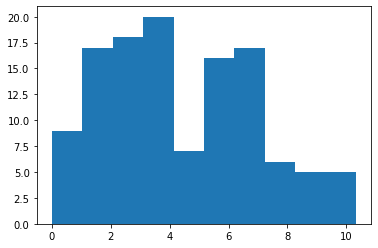

In [ ]:
A=[1,2,3,4,5]
comb=permutations(range(1, 6), 5)
scores=[]
for B in comb:
  score=kendallTau_weighted(A, B)
  scores.append(score)

plt.hist(scores)

In [ ]:
import scipy.stats as stats

def kendallTau(A, B):
    tau, p_value =stats.kendalltau(A, B)
    return tau

def kendallTau_weighted(A, B):
    distance = 0
    for a,b in zip(A,B):
      for (x, y) in zip(a,b):
          if x == y:
              continue
          else:
              distance += np.exp(np.abs(x - y)) / (x + y)
    return distance / 2

def classify(train_embeddings, test_embeddings, scores_train, scores_test, max_score=10.331201022012483, metrics=['mlp', 'gbt', 'lr', 'decision_trees']):

  models = {'mlp': MLPRegressor(random_state=1, max_iter=500),
            'gbt': GradientBoostingRegressor(),
            'lr': LinearRegression(),
            'decision_trees': tree.DecisionTreeRegressor()}
  
  predictions = {x: None for x in metrics}

  for metric in metrics:
    model = models[metric].fit(train_embeddings, scores_train)
    predictions_test = model.predict(test_embeddings).reshape(-1, 5)
    predictions[metric] = np.argsort(np.argsort(predictions_test, axis=1), axis=1) + 1

  scores = scores_test.reshape(-1, 5)
  scores_ranking_test = np.argsort(np.argsort(scores, axis=1), axis=1) + 1

  metric_scores = {x: 0 for x in metrics}
  kendallTau_weighted_dist=defaultdict(list)
  for metric in metric_scores:
    for test, pred in zip (scores_ranking_test, predictions[metric]):
      kendallTau_weighted_dist[metric].append( kendallTau(test, pred ))
    metric_scores[metric] = kendallTau_weighted(scores_ranking_test, predictions[metric])/ (max_score *len(scores_ranking_test))
    print(f" weighted {metric}: {metric_scores[metric]}")
    print(f" kt {metric}: {np.mean(kendallTau_weighted_dist[metric])}")
  return metric_scores,kendallTau_weighted_dist

In [ ]:
metric_scores,kt_scores=classify(train_embeddings,test_embeddings,scores_train,scores_test)

#fusion

In [ ]:
def weighted_combsum(ranks,sims,N=5):
  B = []
  for x in ranks:
    theSum = sum(x)
    y = [float(xi) / theSum for xi in x]
    B.append(y)
  B=np.array([np.array(xi) for xi in B])
  weighted_sims=[]
  for idx, row in enumerate(sims):
    row_b = int(np.floor(idx / N))
    col_b = idx % N
    weighted_sims.append(row * B[row_b][col_b])
  return np.array(weighted_sims).reshape(-1 , N, sims.shape[-1]).sum(axis=1)


In [ ]:
fusion_sims=weighted_combsum(mlp_ranking_test,sims_test)
fusion_sims

array([[ 0.27529226,  0.15983194,  0.1128501 , ..., -0.02110439,
        -0.04664751, -0.0596371 ],
       [ 0.12580134,  0.42086692,  0.04922659, ..., -0.09941072,
        -0.04244234,  0.0699796 ],
       [ 0.22071394,  0.30513001,  0.15574229, ..., -0.05196026,
        -0.11734487, -0.03397107],
       ...,
       [-0.06364513, -0.12712577, -0.02358214, ...,  0.27555121,
         0.15350472,  0.20517202],
       [-0.13714115, -0.0980859 , -0.00694399, ...,  0.30812192,
         0.40083105,  0.29307033],
       [-0.1503727 ,  0.07879422, -0.12505732, ...,  0.0219359 ,
         0.11406078,  0.4132645 ]])

In [ ]:
pd.DataFrame(fusion_sims).to_csv("data/weighted_combsum.csv",index=False)

In [ ]:
pd.read_csv("data/weighted_combsum.csv")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035,1036,1037,1038,1039,1040,1041,1042,1043,1044
0,0.275292,0.159832,0.112850,0.064020,-0.009467,-0.021924,0.068148,0.112343,0.072118,0.073376,0.017117,0.037344,-0.067770,0.097935,0.195703,0.050810,0.075107,0.010866,0.244462,0.082703,0.042794,-0.033365,0.175839,0.063380,0.065013,-0.039215,0.040214,0.177602,0.003702,-0.008705,0.020498,0.047482,-0.060106,0.099026,0.108891,-0.002641,0.118363,0.085647,0.139395,-0.065181,...,-0.052310,0.179602,0.059687,0.058160,0.075478,0.057676,0.052550,-0.032844,-0.011185,0.047401,-0.142998,-0.103871,-0.072408,-0.002182,-0.018293,-0.033867,-0.052475,-0.061471,-0.111213,0.088246,0.014802,0.199332,0.035043,-0.050046,-0.044997,-0.025657,-0.128785,0.081178,0.006002,-0.004311,0.126961,-0.022966,0.090377,-0.155886,-0.125678,-0.084317,0.007936,-0.021104,-0.046648,-0.059637
1,0.125801,0.420867,0.049227,0.014946,-0.187889,0.267463,0.053221,0.167522,-0.008972,-0.048883,0.014089,-0.051522,0.025801,-0.141277,0.080168,-0.095612,0.046681,0.057351,0.131247,-0.120684,0.091742,0.050831,-0.024950,-0.129333,-0.108507,-0.062587,0.183964,-0.007621,0.109278,0.257133,-0.040723,0.066876,-0.059262,0.143002,0.181583,0.112817,-0.072336,-0.179840,-0.151773,0.063940,...,0.142222,-0.088493,0.184767,0.162578,0.127407,-0.083969,-0.127682,0.269669,0.127482,-0.070099,-0.082816,-0.051352,-0.117839,0.020191,-0.053409,0.160420,-0.154143,0.067624,-0.059011,0.256287,-0.108323,0.106717,-0.135850,0.087705,0.020297,0.269807,-0.028866,-0.093009,0.037988,0.159964,-0.001569,0.273460,0.053351,0.047564,-0.080678,-0.049833,0.010642,-0.099411,-0.042442,0.069980
2,0.220714,0.305130,0.155742,0.073406,-0.142970,-0.027141,-0.035932,0.057333,0.170311,-0.116393,-0.011347,-0.021059,0.188125,-0.031432,0.156042,-0.088954,0.188892,0.133590,0.260810,-0.023746,0.113814,-0.069647,0.055132,0.003257,-0.101417,-0.135579,0.202047,-0.017611,-0.033633,-0.023195,-0.089687,-0.113630,-0.013310,0.292618,0.097916,0.223742,0.113739,-0.143973,-0.121985,0.063730,...,0.146747,-0.058183,-0.032611,0.128920,-0.008297,-0.079081,-0.100026,-0.020605,0.212390,-0.003173,-0.057787,0.056352,-0.020047,0.025042,-0.045150,-0.039610,-0.103053,0.175973,-0.027412,0.098205,0.002413,0.249630,-0.084174,-0.060918,-0.007571,-0.046823,-0.023941,-0.078807,0.126401,0.141106,0.035429,-0.032420,-0.045256,0.053557,-0.092068,0.013104,0.105268,-0.051960,-0.117345,-0.033971
3,0.277324,-0.013389,0.137693,0.312055,0.225326,-0.169451,0.159233,0.099509,0.039510,0.238519,-0.025304,0.229302,-0.092621,0.264553,0.067922,-0.007838,0.151272,-0.044673,0.152662,0.336950,0.016106,-0.078258,0.058255,0.153941,0.289360,-0.097105,-0.051667,0.078963,0.017615,-0.155559,0.176510,-0.019529,-0.120224,0.110208,-0.016887,0.024330,0.028685,0.086619,0.237361,-0.038010,...,-0.150908,0.223017,-0.130999,-0.029443,0.020484,0.012413,0.029066,-0.176534,-0.126969,0.173638,-0.118521,-0.129341,0.090181,-0.024858,-0.116759,-0.128740,-0.077448,-0.027728,-0.039855,-0.122562,-0.021999,0.159175,0.090644,-0.187284,-0.101940,-0.164416,-0.147949,0.026158,0.051771,-0.158117,0.146527,-0.159966,-0.115000,-0.166499,-0.163559,-0.141338,0.037071,0.000782,-0.106802,-0.117808
4,0.217814,0.058239,-0.019025,0.281458,0.396339,-0.010875,0.236469,0.181197,-0.026004,0.348013,0.106176,0.038411,-0.097869,0.117141,-0.006998,-0.041867,-0.004757,-0.088803,0.061574,0.199761,0.020677,0.079972,0.076637,0.153203,0.147065,-0.013831,-0.020630,0.024483,0.007354,0.013258,0.338315,0.112671,-0.108275,0.096651,-0.080836,0.073588,0.009142,0.056695,0.231774,0.003552,...,-0.104739,0.164025,-0.107300,-0.000591,0.022915,0.030470,0.063856,-0.023955,-0.143629,-0.072458,-0.049172,-0.185073,0.307338,-0.015019,-0.109688,0.051459,-0.092698,-0.012753,0.107214,-0.122297,-0.037545,0.167310,-0.035293,-0.182964,-0.094341,-0.048